In [1]:
from fastai.vision import *
import fastai
os.environ['CUDA_LAUNCH_BLOCKING']='1'
defaults.device = torch.device('cuda:0')


In [2]:
%load_ext autoreload
%autoreload
down_dir = Path(os.path.join('.', 'data', 'chictopia'))
photos_lmdb_path = 'data/chictopia/photos.lmdb'
moda_json = Path('modanet2018_instances_train.json')
data_dir = 'Images'  # It is better to have a seperate folder for the Moda data
train_dir = os.path.join(down_dir, data_dir,'train') # A folder for raw images
mask_dir = os.path.join(down_dir, data_dir,'train_masks')# A folder for masks
manifest_dir = Path('./manifest.pickle') # Manifest of the path images and their corresponding mask path

In [6]:
%autoreload
manifest_dir = Path('./manifest3.pickle')
if (os.path.exists(manifest_dir)):
    with open(manifest_dir, 'rb') as handle:
        manifest = pickle.load(handle)
else:
    manifest = COCO_.generate_masks(train_dir, mask_dir,moda_json)
    with open(manifest_dir, 'wb') as handle:
        pickle.dump(manifest, handle, protocol=pickle.HIGHEST_PROTOCOL)
m3= manifest
cat_dir = os.path.join(train_dir,'outer_dress_more')
get_y_fn = lambda x: manifest[x.as_posix()]


In [12]:
manifest = m1

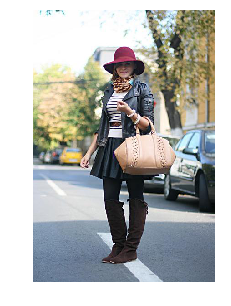

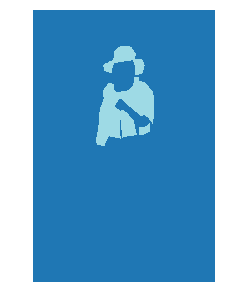

In [13]:
fnames = get_image_files(cat_dir)
lbl_names = get_image_files(mask_dir)
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))
mask = open_mask(get_y_fn(img_f))
#print(fnames[10])
mask.show(figsize=(5, 5), alpha=1)

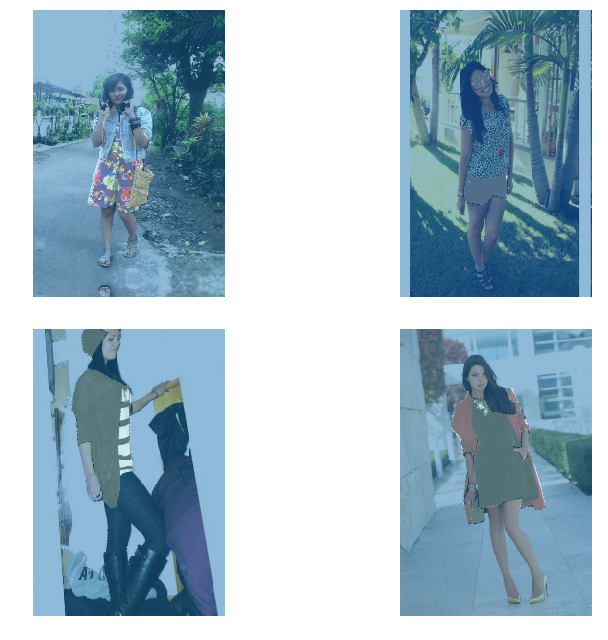

In [14]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs = 4
codes = ['outer','top','headwear','shorts','sunglasses','dress','bag']
src = (SegmentationItemList.from_folder(cat_dir)
       # Load in x data from folder
       .split_by_rand_pct()
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

data.show_batch(rows=3, figsize=(12, 9))

In [15]:
learn = unet_learner(data, models.resnet34, wd=1e-2)
print(type(learn.model))
learn.summary()



<class 'fastai.vision.models.unet.DynamicUnet'>


Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 100]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 100]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 50]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 50]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 75, 50]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 50]         0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


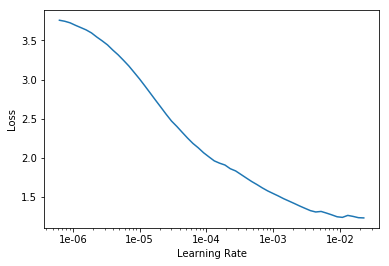

In [7]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate grap

In [16]:
lr = 1e-03 # pick a lr
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.142127,0.126901,10:04
1,0.137110,0.127220,09:58
2,0.124556,0.110374,09:56
3,0.117637,0.100584,09:56
4,0.099948,0.090929,09:55
5,0.100076,0.088600,09:56
6,0.085772,0.082608,09:56
7,0.071713,0.079705,09:57
8,0.073641,0.078707,09:57
9,0.071017,0.078923,09:59


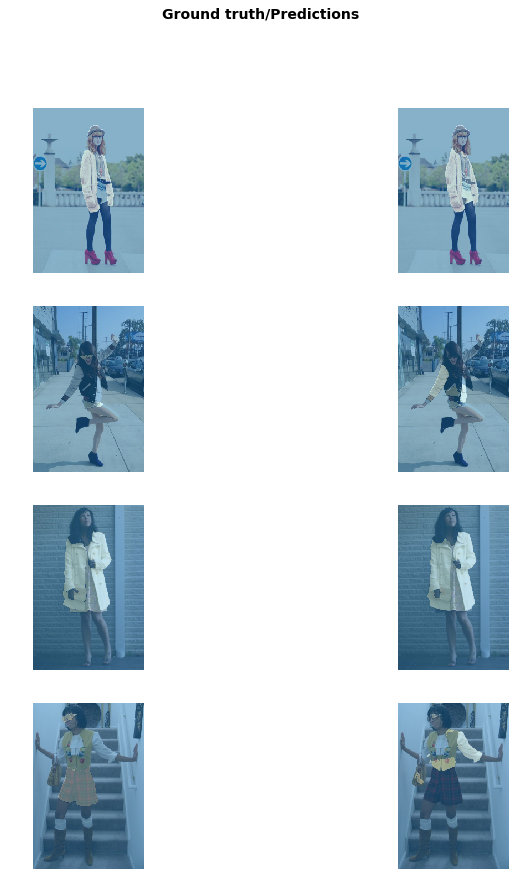

In [20]:
learn.show_results(rows=5, figsize=(12, 14))

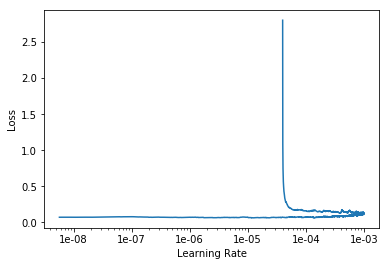

In [21]:
learn.unfreeze()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(6, slice(lr/100))

epoch,train_loss,valid_loss,time
0,0.066252,0.079489,11:00
1,0.067795,0.079452,11:02
2,0.074582,0.078741,11:05
3,0.066648,0.079436,10:53
4,0.064397,0.078810,10:54
5,0.061920,0.079713,10:53


In [ ]:
learn.summary()

In [23]:
learn.export("/home/zerowitone/Desktop/Fellowship.ai/paperdoll/"+"Unet_{}_{}".format("model", "V4"))
